In [1]:
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm

# Load the datasets
merged_data = pd.read_excel('Merged_Funds_Factors_Data.xlsx')
beta_1_results_2018_2021 = pd.read_excel('Beta_1_Results_2018_2021.xlsx')
beta_1_results_2021_2024 = pd.read_excel('Beta_1_Results_2021_2024.xlsx')

# Define the periods
period_1_start = '2018-03-31'
period_1_end = '2021-03-31'
period_2_start = '2021-03-31'
period_2_end = '2024-03-31'

# Filter the data for each period
period_1_data = merged_data[(merged_data['Date'] >= period_1_start) & (merged_data['Date'] <= period_1_end)]
period_2_data = merged_data[(merged_data['Date'] >= period_2_start) & (merged_data['Date'] <= period_2_end)]


In [3]:
def run_alpha_regression(data, beta_1_results, period_name, start_year, min_obs=6, min_r_squared=0.30):
    results = []
    funds = data['ISIN'].unique()
    for fund in tqdm(funds, desc=f"Processing {period_name}"):
        fund_data = data[data['ISIN'] == fund]
        beta_1 = beta_1_results[beta_1_results['ISIN'] == fund]['Beta_1'].values
        if fund_data.shape[0] >= min_obs and len(beta_1) > 0:
            for year in range(1, 4):
                annual_data = fund_data[(fund_data['Date'] >= f'{start_year + year - 1}-01-01') &
                                        (fund_data['Date'] < f'{start_year + year}-01-01')]
                if annual_data.shape[0] >= min_obs:
                    X = annual_data[['SMB', 'HML', 'MOM', 'RMW', 'CMA']]
                    y = annual_data['Return'] - annual_data['RF'] - beta_1[0] * annual_data['Mkt-RF']
                    X = sm.add_constant(X)
                    model = sm.OLS(y, X).fit()
                    if model.rsquared >= min_r_squared:
                        alpha = model.params['const']
                        results.append({'ISIN': fund, 'Period': f'{start_year + year - 1}', 'Alpha': alpha, 'R-Squared': model.rsquared, 'Model Summary': model.summary()})
    return results


In [6]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="kurtosistest only valid for n>=20")

# Run alpha regression for each period
results_alpha_1 = run_alpha_regression(period_1_data, beta_1_results_2018_2021, '2018-2021', 2018)
results_alpha_2 = run_alpha_regression(period_2_data, beta_1_results_2021_2024, '2021-2024', 2021)

# Convert results to DataFrame
results_alpha_df_1 = pd.DataFrame(results_alpha_1)
results_alpha_df_2 = pd.DataFrame(results_alpha_2)

# Save the results
results_alpha_df_1.to_excel('Alpha_Results_2018_2021.xlsx', index=False)
results_alpha_df_2.to_excel('Alpha_Results_2021_2024.xlsx', index=False)

print("Alpha regression results saved as 'Alpha_Results_2018_2021.xlsx' and 'Alpha_Results_2021_2024.xlsx'.")


Processing 2021-2024: 100%|██████████| 8199/8199 [08:44<00:00, 15.64it/s]  


Alpha regression results saved as 'Alpha_Results_2018_2021.xlsx' and 'Alpha_Results_2021_2024.xlsx'.


Descriptive Statistics for Alpha Values:
count    21078.000000
mean        -0.143248
std          0.961219
min         -4.546442
25%         -0.721402
50%         -0.176779
75%          0.360570
max          5.864655
Name: Alpha, dtype: float64

Number of Outliers in Alpha Values: 675

Outliers in Alpha Values:
               ISIN  Period     Alpha  R-Squared  \
283    CH0037975858    2019  2.072281   0.474130   
342    CH0192250600    2020  3.390263   0.900083   
421    CH0315621927    2020  2.778909   0.640801   
664    FR0000281966    2018  2.002361   0.760258   
742    FR0007005624    2020 -2.593736   0.403704   
...             ...     ...       ...        ...   
21047  SE0010920470    2023  2.896545   0.651662   
21050  SE0010920488    2023  2.972136   0.609847   
21068  SE0012039519    2023  2.530895   0.574710   
21071  SE0012039527    2023  2.513230   0.615832   
21077  SE0014401303    2023  2.469538   0.574899   

                                           Model Summary  
283

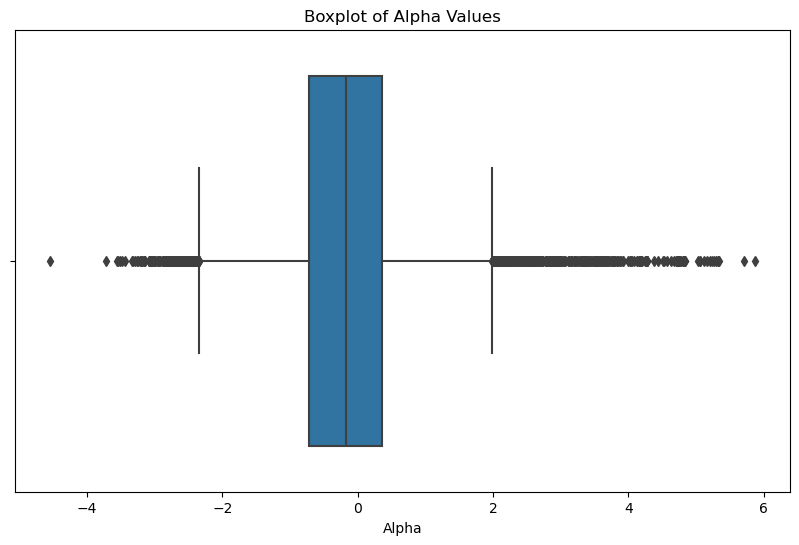

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the alpha results
alpha_results_2018_2021 = pd.read_excel('Alpha_Results_2018_2021.xlsx')
alpha_results_2021_2024 = pd.read_excel('Alpha_Results_2021_2024.xlsx')

# Combine both results for a comprehensive analysis
alpha_results = pd.concat([alpha_results_2018_2021, alpha_results_2021_2024], ignore_index=True)

# Descriptive statistics for alpha values
descriptive_stats = alpha_results['Alpha'].describe()
print("Descriptive Statistics for Alpha Values:")
print(descriptive_stats)

# Detecting outliers using IQR method
Q1 = alpha_results['Alpha'].quantile(0.25)
Q3 = alpha_results['Alpha'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = alpha_results[(alpha_results['Alpha'] < lower_bound) | (alpha_results['Alpha'] > upper_bound)]
num_outliers = outliers.shape[0]

print("\nNumber of Outliers in Alpha Values:", num_outliers)

# Display the outliers
print("\nOutliers in Alpha Values:")
print(outliers)

# Boxplot to visualize alpha values and outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=alpha_results['Alpha'])
plt.title('Boxplot of Alpha Values')
plt.show()
